# 01 - Accessing and querying the Survey Class and HDF5 file

The survey HDF5 file is a master look up table for each observation made by VIRUS for HETDEX. It can be accessed directly through the HDF5 survey file, or through the Survey class API. The Survey class includes information for each three dither set HETDEX observation in HDR1. It includes both science and calibration shots. Any quantity related to an individual dither is provided in an array of length three. Fundamental properties of a shot and quality assessment values for seeing (fwhm), astrometry, flux limits and transparency (response_4540) are tabulated to allow for querying of desired shots. 

We first introduce the basic API to query the Survey Class by sky coordinates to get a list of shots where fibers are located within that region. Later on in this notebook we show some basic querying of the Survey class and demonstrate a few examples.

### Initiate the Survey class :

In [1]:
%matplotlib inline
import tables as tb
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

from hetdex_api.survey import Survey, FiberIndex

In [2]:
survey = Survey('hdr2')

This calls the HDR1 survey class and sets each column in the survey table as an attribute to this object. This is how it looks through an astropy Table object:

In [3]:
survey_table=survey.return_astropy_table()

In [4]:
survey_table

shotid,field,objid,date,obsid,ra,dec,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,relflux_virus [3],ambtemp,darktime [3],datevobs,dewpoint,expnum [3],exptime [3],humidity,mjd [3],nstars_fit [3],nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra,xditherpos [3],xoffset [3],xrms [3],yditherpos [3],yoffset [3],yrms [3],shot_flag
int64,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,float32,float32,bytes12,float32,int32,float32,float32,float32,int32,int32,int32,float32,float32,bytes7,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool
20170103002,cosmos,COS10_W_000_W,20170103,2,149.887695,1.885366,213.616553,14,2.3224666,0.33501986,0.09,0.83899117 .. 1.208469,7.055,395.0349 .. 395.08752,20170103v002,-7.0894446,1 .. 3,365.29913 .. 364.9993,34.054,57756.465 .. 57756.473,7 .. 7,7,1,800.37286,218.2631,1109049,1.886055,212.19806,149.886,0.0 .. 1.5292,-0.0 .. 1e-05,0.19808 .. 0.28259,0.0 .. 0.5084,-0.0 .. 0.0,0.28311 .. 0.26157,True
20170103003,cosmos,COS64_W,20170103,3,150.485883,2.483296,215.160015,14,1.9453459,0.70668113,0.0437,1.1756307 .. 0.8494048,7.111111,394.85974 .. 395.2984,20170103v003,-7.351111,1 .. 3,364.89917 .. 365.1494,33.338,57756.484 .. 57756.492,3 .. 3,4,1,800.37286,220.17468,1135427,2.483722,213.73126,150.4845,0.0 .. 1.2627,-2e-05 .. 0.0,0.01868 .. 0.10318,0.0 .. 1.7278,2e-05 .. 3e-05,0.01476 .. 0.39071,True
20170105008,cosmos,COS57_E,20170105,8,149.771392,2.592347,147.352919,14,2.4116552,0.27407384,0.1007,0.77864236 .. 1.2305791,10.595,392.88577 .. 395.38724,20170105v008,-1.4522222,1 .. 3,362.6497 .. 365.34888,42.01,57758.336 .. 57758.348,4 .. 4,4,1,796.5801,139.48857,0806287,2.591758,146.0002,149.772,0.0 .. 1.5756,-0.0 .. 0.0,0.21676 .. 0.18716,0.0 .. 1.5143,0.0 .. -0.0,0.16183 .. 0.0861,True
20170105009,cosmos,COS19_E_000_E,20170105,9,149.97293,2.091282,148.690592,14,3.0098238,0.17375052,0.0698,1.1348697 .. 0.81575423,10.82,395.13513 .. 394.24307,20170105v009,-0.50222224,1 .. 3,365.0495 .. 362.64868,44.681,57758.36 .. 57758.367,3 .. 3,5,1,796.5801,141.07867,0838053,2.090136,147.27345,149.9715,0.0 .. 2.7508,-7e-05 .. -1e-05,0.31348 .. 0.02273,0.0 .. 1.0052,0.00032 .. 0.0,0.38061 .. 0.21452,True
20170105010,cosmos,COS1_W,20170105,10,149.788237,1.78615,213.329534,14,2.0568435,0.17912686,0.1279,0.8645878 .. 1.1153272,9.510555,395.5891 .. 394.662,20170105v010,-0.22388889,1 .. 3,365.14957 .. 364.95065,50.362,57758.46 .. 57758.47,7 .. 8,7,1,796.2076,217.93459,1101477,1.786439,211.93365,149.787,0.0 .. 2.1155,0.0 .. 0.0,0.71585 .. 0.64878,0.0 .. 1.4337,-0.0 .. -0.0,0.31281 .. 0.2366,True
20170105011,cosmos,COS14_W,20170105,11,150.287775,1.886035,213.74048,14,2.6563892,0.52853006,0.0718,1.241345 .. 0.77688354,9.596666,395.08527 .. 395.28873,20170105v011,0.12388889,1 .. 3,365.2006 .. 365.0496,51.564,57758.48 .. 57758.49,5 .. 3,6,1,796.2076,218.2599,1130484,1.886055,212.19548,150.2865,0.0 .. 0.1096,0.0 .. 1e-05,0.281 .. 0.27286,0.0 .. 2.1655,0.0 .. 1e-05,0.88719 .. 0.41315,True
20170106001,cosmos,COS18_E,20170106,1,149.872346,2.091178,148.663047,14,2.0175648,0.493342,0.0642,0.76809865 .. 1.2480891,9.454445,395.43484 .. 395.2338,20170106v001,-3.6533334,1 .. 3,365.35022 .. 365.299,39.457,57759.336 .. 57759.344,7 .. 7,7,1,794.24347,141.08037,0804099,2.090136,147.27481,149.871,0.0 .. 0.2394,5e-05 .. -2e-05,0.88333 .. 0.88421,0.0 .. 0.8497,8e-05 .. 4e-05,0.6588 .. 0.65531,True
20170106002,cosmos,COS10_E,20170106,2,149.87241,1.99063,148.885585,14,2.6078148,0.37767038,0.1025,1.1572015 .. 0.81802744,9.538333,393.13885 .. 394.58774,20170106v002,-3.4677777,1 .. 3,363.09958 .. 364.94952,39.525,57759.355 .. 57759.367,8 .. 7,7,1,794.24347,141.40508,0834078,1.989807,147.53558,149.871,0.0 .. 1.5108,-1e-05 .. -5e-05,0.1938 .. 0.7087,0.0 .. 0.0065,0.0 .. 2e-05,0.1416 .. 0.33973,True
20170106003,cosmos,COS19_W,20170106,3,149.988279,1.985643,213.927043,14,3.0485,0.015947422,0.066,1.2205125 .. 0.84155726,8.274445,396.4476 .. 394.98724,20170106v003,-4.513333

It also converts RA and DEC into astropy coordinate objects.

In [5]:
survey.coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(149.887695,  1.885366), (150.485883,  2.483296),
     (149.771392,  2.592347), ..., (212.856128, 51.488692),
     (219.037086, 52.088549), (166.514558, 50.290787)]>

Shots are labeled based on their observation date and observation ID:

In [6]:
survey.date

array([20170103, 20170103, 20170105, ..., 20200203, 20200203, 20200204],
      dtype=int32)

In [7]:
survey.obsid

array([ 2,  3,  8, ..., 24, 25, 21], dtype=int32)

A specific shot can be linked either by an integer combination of these two values, called `shotid`, or the `DATEvOBS` form:

In [8]:
survey.datevobs

array(['20170103v002', '20170103v003', '20170105v008', ...,
       '20200203v024', '20200203v025', '20200204v021'], dtype='<U12')

In [9]:
survey.shotid

array([20170103002, 20170103003, 20170105008, ..., 20200203024,
       20200203025, 20200204021])

## Searching for shots near a sky coordinate

Most users searching for observations will want to get a list of observations/shots at a specific sky position. Each shot has a single associated sky coordinate. We can retrieve a list of shots that may contain fibers in a specific region. However, because of the varying and non-contiguous footprint of VIRUS, this is not an immediate guarantee a region has been observed. You must further query fibers in each shot to determine this. See Notebook 02 to learn how to query with the Fibers Class API. 

### get_shotlist()
This function which operates on the Survey class object. An astropy coordinates object is required as input.

In [10]:
coords = SkyCoord(11.628530 * u.deg, 0.081790 * u.deg, frame='icrs')

We can either search a rectangular region, width and height in degrees:

In [11]:
shotlist = survey.get_shotlist(coords, width=0.5, height=0.2)

In [12]:
shotlist

array([20171119003, 20180106004, 20181003009, 20181005017, 20181107014,
       20191222012])

or we can search a circular aperture with a radius given in degress, or in an astropy quantity object:

In [13]:
shotlist = survey.get_shotlist(coords, radius=10*u.arcmin)

In [14]:
shotlist

array([20171119003, 20180106004, 20181003009, 20181107014, 20191222012])

From here a user can take their shotlist and query the position on the Fibers class and see if their region of interest is observed in the survey.

## Basic querying for the Survey Class

The Survey HDF5 itself contains information about the quality of each observation. A user can query different parameters and plot up general shot quantities. For example, we can compare the distribution of throughput values (technically the response at 4540 AA) between the HETDEX spring and HETDEX fall fields:

### Example: Plotting up the canonical throughput value at 4540 AA

In [15]:
idx_spring = np.where( (survey.field == 'dex-spring') * np.isfinite(survey.response_4540) )

In [16]:
idx_fall = np.where( (survey.field == 'dex-fall') * np.isfinite(survey.response_4540))

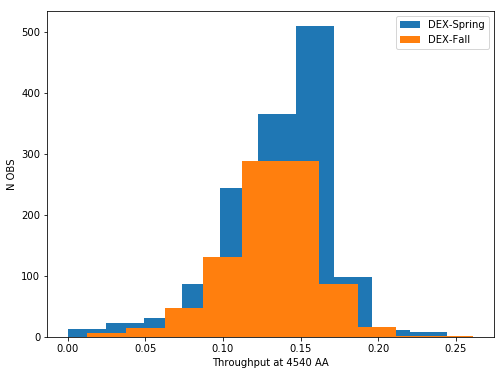

In [17]:
plt.figure(figsize=(8,6))
plt.hist(survey.response_4540[idx_spring], label = 'DEX-Spring')
plt.hist(survey.response_4540[idx_fall], label = 'DEX-Fall')
plt.xlabel('Throughput at 4540 AA')
plt.ylabel('N OBS')
plt.legend()

### Example: Plotting up the locations of all cosmos shots:

In [18]:
idx_cosmos = np.where(survey.field == 'cosmos')

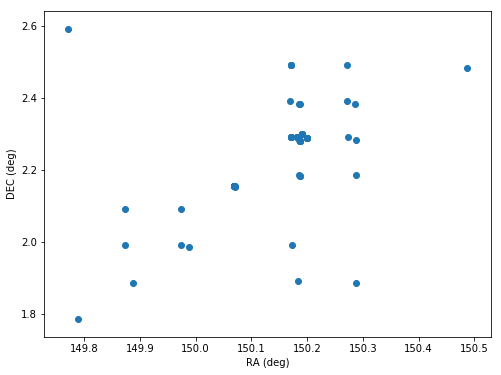

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(survey.ra[idx_cosmos],survey.dec[idx_cosmos])
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.show()

# Accessing the Master Fiber Index Table:

New to HDR2 is a Master Fiber Index table for all Fibers in the HDR2 survey. This file can be accessed through the FiberIndex class:

In [20]:
FibIndex = FiberIndex()

In [21]:
coords = SkyCoord(11.628530 * u.deg, 0.081790 * u.deg, frame='icrs')

In [22]:
coords.ra.deg

11.62853

You can read in a circular region of the Fiber Index table using the query_region() function:

In [23]:
fiber_table_region = FibIndex.query_region(coords, radius=3.*u.arcsec, shotid=None, astropy=True)

In [24]:
fiber_table_region

multiframe,ra,dec,fiber_id,healpix,amp,expnum,fibidx,fibnum,fpx,fpy,ifuid,ifuslot,ifux,ifuy,shotid,specid
bytes20,float32,float32,bytes38,int64,bytes2,int32,int32,int32,float32,float32,bytes3,bytes3,float32,float32,int64,bytes3
multi_308_047_024_LL,11.627942,0.0814511,20181003009_1_multi_308_047_024_LL_079,6433214601,LL,1,78,79,-251.53,-158.53,024,047,-1.27,-8.81,2018100300,308
multi_308_047_024_LL,11.628648,0.0813975,20181003009_1_multi_308_047_024_LL_098,6433214601,LL,1,97,98,-250.26,-160.74,024,047,0.0,-11.02,2018100300,308
multi_308_047_024_LL,11.628344,0.0820341,20181003009_1_multi_308_047_024_LL_099,6433214601,LL,1,98,99,-252.8,-160.74,024,047,-2.54,-11.02,2018100300,308
multi_308_047_024_LU,11.629047,0.0819793,20181003009_1_multi_308_047_024_LU_006,6433083530,LU,1,5,6,-251.53,-162.94,024,047,-1.27,-13.22,2018100300,308
multi_308_047_024_LL,11.628618,0.0810092,20181003009_3_multi_308_047_024_LL_098,6433345674,LL,3,97,98,-249.045,-160.04,024,047,0.0,-11.02,2018100300,308
multi_308_047_024_LL,11.628314,0.0816458,20181003009_3_multi_308_047_024_LL_099,6433214601,LL,3,98,99,-251.585,-160.04,024,047,-2.54,-11.02,2018100300,308
multi_308_047_024_LL,11.62801,0.0822824,20181003009_3_multi_308_047_024_LL_100,6433214601,LL,3,99,100,-254.125,-160.04,024,047,-5.08,-11.02,2018100300,308
multi_308_047_024_LU,11.629018,0.0815909,20181003009_3_multi_308_047_024_LU_006,6433214601,LU,3,5,6,-250.315,-162.24,024,047,-1.27,-13.22,2018100300,308
multi_308_047_024_LU,11.628714,0.0822275,20181003009_3_multi_308_047_024_LU_007,6433083530,LU,3,6,7,-252.855,-162.24,024,047,-3.81,-13.22,2018100300,308


Note: you have the option to request a specific shotid (default is None) or whether to return an astropy table format or not. Default is to return an astropy table.

In [28]:
healpix_table = FibIndex.get_fib_from_hp(6433214603)

In [27]:
healpix_table

multiframe,ra,dec,fiber_id,healpix,amp,expnum,fibidx,fibnum,fpx,fpy,ifuid,ifuslot,ifux,ifuy,shotid,specid
bytes20,float32,float32,bytes38,int64,bytes2,int32,int32,int32,float32,float32,bytes3,bytes3,float32,float32,int64,bytes3
multi_308_047_024_LU,11.629352,0.0813427,20181003009_1_multi_308_047_024_LU_005,6433214602,LU,1,4,5,-248.99,-162.94,024,047,1.27,-13.22,2018100300,308
multi_308_047_024_LU,11.63036,0.0806513,20181003009_1_multi_308_047_024_LU_023,6433214602,LU,1,22,23,-245.18,-165.14,024,047,5.08,-15.42,2018100300,308
multi_308_047_024_LU,11.630055,0.0812879,20181003009_1_multi_308_047_024_LU_024,6433214602,LU,1,23,24,-247.72,-165.14,024,047,2.54,-15.42,2018100300,308
multi_308_047_024_LU,11.629751,0.0819245,20181003009_1_multi_308_047_024_LU_025,6433214602,LU,1,24,25,-250.26,-165.14,024,047,0.0,-15.42,2018100300,308
multi_308_047_024_LU,11.630761,0.0812343,20181003009_1_multi_308_047_024_LU_043,6433214602,LU,1,42,43,-246.45,-167.35,024,047,3.81,-17.63,2018100300,308
multi_308_047_024_LU,11.630457,0.0818709,20181003009_1_multi_308_047_024_LU_044,6433214602,LU,1,43,44,-248.99,-167.35,024,047,1.27,-17.63,2018100300,308
multi_308_047_024_LU,11.630153,0.0825075,20181003009_1_multi_308_047_024_LU_045,6433214602,LU,1,44,45,-251.53,-167.35,024,047,-1.27,-17.63,2018100300,308
multi_308_047_024_LU,11.631161,0.0818161,20181003009_1_multi_308_047_024_LU_063,6433214602,LU,1,62,63,-247.72,-169.55,024,047,2.54,-19.83,2018100300,308
multi_308_047_024_LU,11.630025,0.0808995,20181003009_3_multi_308_047_024_LU_024,6433214602,LU,3,23,24,-246.505,-164.44,024,047,2.54,-15.42,2018100300,308


In [29]:
healpix = FibIndex.hdfile.root.FiberIndex.cols.healpix[:]

In [32]:
np.size(np.unique(healpix))

130219289

Other access should be done directly through pytables, for example. The table is optimized for querying on 'ra', 'fiber_id' and 'healpix' integer.

In [28]:
fiber_id_i =  '20181003009_2_multi_308_047_024_LL_080'
fiber_table = FibIndex.hdfile.root.FiberIndex.read_where('fiber_id == fiber_id_i')
Table(fiber_table)

multiframe,ra,dec,fiber_id,healpix,amp,expnum,fibidx,fibnum,fpx,fpy,ifuid,ifuslot,ifux,ifuy,shotid,specid
bytes20,float32,float32,bytes38,int64,bytes2,int32,int32,int32,float32,float32,bytes3,bytes3,float32,float32,int64,bytes3
multi_308_047_024_LL,11.627959,0.081867,20181003009_2_multi_308_047_024_LL_080,411727070284,LL,2,79,80,-252.855,-159.23,024,047,-3.81,-8.81,2018100300,308


## Exploring the Survey HDF5 File

The hdfile attribute contains the link to the survey HDF5 file. Calling it will show you all the information in the HDF5 file. You may interact with this directly rather than using the Survey class initiation. 


In [27]:
survey.hdfile

File(filename=/data/05350/ecooper/hdr2/survey/survey_hdr2.h5, title='HDR2Survey file ', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'HDR2Survey file '
/Survey (Table(2489,)) ''
  description := {
  "shotid": Int64Col(shape=(), dflt=0, pos=0),
  "field": StringCol(itemsize=12, shape=(), dflt=b'', pos=1),
  "objid": StringCol(itemsize=18, shape=(), dflt=b'', pos=2),
  "date": Int32Col(shape=(), dflt=0, pos=3),
  "obsid": Int32Col(shape=(), dflt=0, pos=4),
  "ra": Float64Col(shape=(), dflt=0.0, pos=5),
  "dec": Float64Col(shape=(), dflt=0.0, pos=6),
  "pa": Float64Col(shape=(), dflt=0.0, pos=7),
  "n_ifu": Int32Col(shape=(), dflt=0, pos=8),
  "fwhm_virus": Float32Col(shape=(), dflt=0.0, pos=9),
  "fwhm_virus_err": Float32Col(shape=(), dflt=0.0, pos=10),
  "response_4540": Float32Col(shape=(), dflt=0.0, pos=11),
  "relflux_virus": Float32Col(shape=(3,), dflt=0.0, pos=12),
  "ambtemp": F